In [1]:
import numpy as np
import pandas as pd
import fabio
import matplotlib as mpl
import matplotlib.pyplot as plt
import kkcalc
from kkcalc import data
from kkcalc import kk
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

from Reduction_Analysis import Reduction, Calculation
from Indexing import Indexing

C:\Users\Phong\anaconda3\envs\DopantModeling-dev\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Mapping detector images to $q$-space

The X-ray scattering detector is typically a 2D surface, that we would like to use to map the reciprocal lattice, and in turn, learn about real-space structure. Because the condition for Bragg diffraction requires that points on the reciprocal lattice lay on the surface of the Ewald sphere, the X-ray scattering detector is really capturing a projection of the 3D Ewald sphere surface filtered by overlapping points of the reciprocal lattice. 

You might imagine that points at larger angles from the incident beam must travel farther to reach the flat detector surface. To account for this, we must geometrically re-map the detector pixels to account for the curvature of the Ewald sphere. The correction of intensity variation as a function of angle (solid-angle correction) is also required.

Load the X-ray scattering detector .tif image file, orient it, and make sure the beam center appears where it should

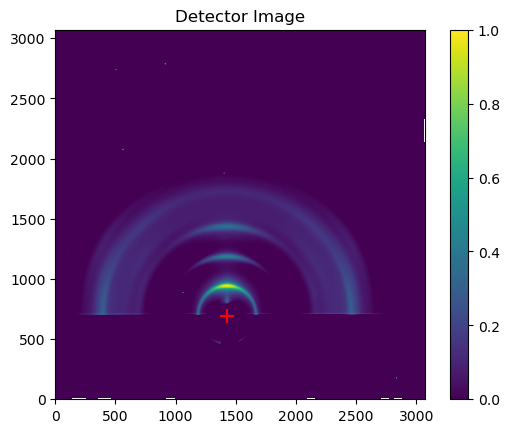

In [2]:
processor = Reduction()

file = r'.\example_data\EPEN_0p1deg_120s_08241133_0001.tif'

px_size_x, px_size_y = 0.073242, 0.073242 # mm, mm
bc_x, bc_y = 1427.66, 2381.05 # pixel coordinates
R = 289.52 # mm
xray_en= 12.7 # keV
q_range = 2 # inv A
q_res = 0.005 # inv A
incidence = 0.1 # degrees

image = np.flipud(fabio.open(file).data)
# Auto masking is optional - additional info is included in the source code
masked_image, mask = processor.automask(image, threshold_value=2)

plt.imshow(masked_image, origin = 'lower', norm=LogNorm(np.nanpercentile(image, 80)))
plt.scatter(bc_x, image.shape[1] - bc_y, color='red', s=100, marker='+', label='Beam Center')
plt.colorbar()
plt.title('Detector Image')
plt.show()

Map the detector image to $q$-space and apply intensity corrections

In [3]:
qzqxy = processor.img_to_qzqxy(masked_image, bc_x, bc_y, R, incidence, px_size_x, px_size_y, q_range, q_res, xray_en)

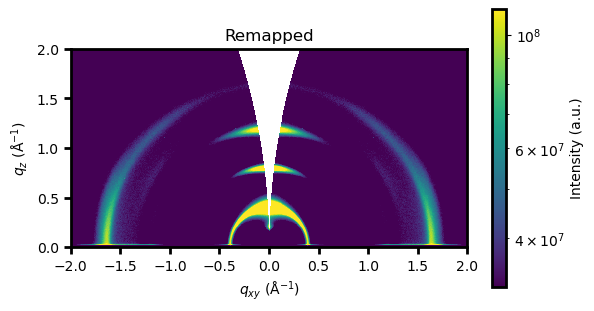

In [4]:
fig, ax = processor.plot_qzqxy(qzqxy, cmap='viridis')
plt.title('Remapped')
plt.show()

For analysis, it's often useful to convert from Cartesion to polar coordinates. 

For instance, consider that because the 2D detector is oriented relative to the sample substrate and incident beam, true sampling of scattering from the entire $xy$ plane would require rotation of the sample about it's surface normal and accounting for the additional sampling along the $q_{z}$ direction. Or, if we have samples that exhibit in-plane isotropy or are uniform for all rotations, then we can simply account for the fact that we have sampled less of the true $xy$ plane in a single image by multiplying scattering intensity as a function of the angle from the $q_z$ to $q_{xy}$ axis (azimuthal angle, $\chi$) by a factor of $|\text{sin}(\chi)|$.

In [5]:
chiq, corrected_chiq = processor.cake_and_corr(qzqxy)

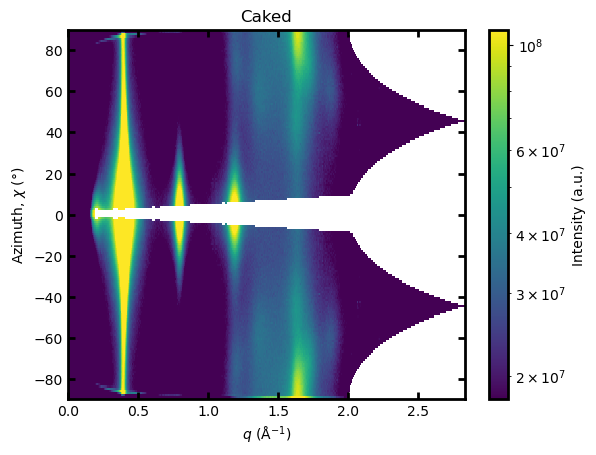

In [6]:
fig, ax = processor.plot_chiq(chiq, cmap='viridis')
plt.title('Caked')
plt.show()

Note how the $|\text{sin}(\chi)|$-corrected image reduces the intensity near 0° where $|\text{sin}(\chi)| = 0$.

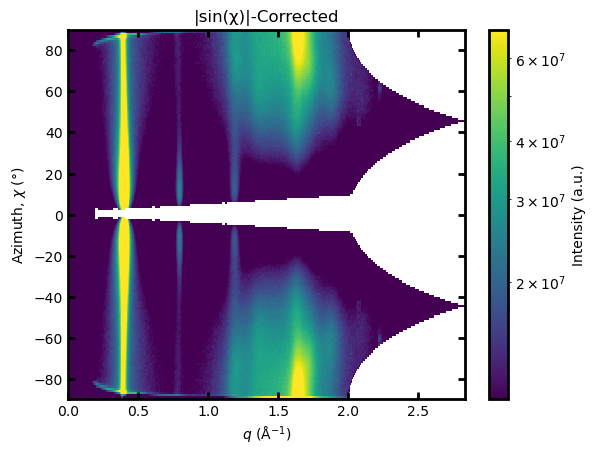

In [7]:
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')
plt.title('|sin(χ)|-Corrected')
plt.show()

Now that we have the processed images, we can try indexing the peaks. This library only provides rudimentary tools for trial-and-error indexing.

Here, you can play with the space group, lattice dimensions, angles, and Miller indices to index. Assuming you don't know orientation, the plot simply draws lines at the $q$-values where the resultant peaks are expected.

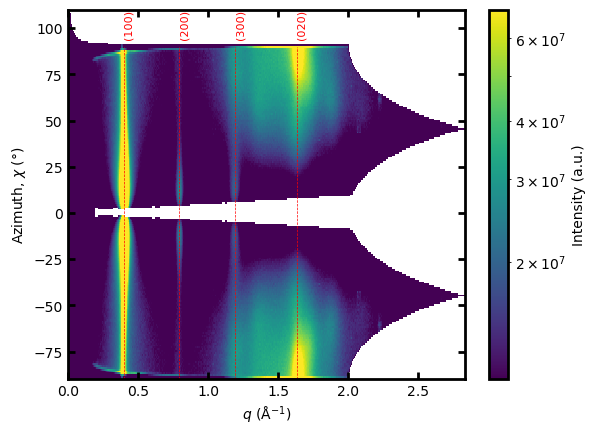

In [8]:
# Set display options for pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Initialize custom Miller indices and other parameters
custom_miller_indices = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (0, 2, 0)]
# custom_miller_indices = []
max_miller_index = 3
space_group = 'monoclinic'
a = 15.8
b = 7.7
c = 7.6
alpha = 90
beta = 90
gamma = 87

# Create an object of CrystalIndexingAnalyzer
analyzer = Indexing(space_group, a, b, c, alpha, beta, gamma)

# Call the compute_spacing method
spacing_table = analyzer.compute_spacing(custom_miller_indices, max_miller_index)

# Sort the DataFrame by QSpace_AngstromInverse in ascending order
spacing_table = spacing_table.sort_values(by='QSpace_AngstromInverse')
                         
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

ax.set_ylim([-90, 110])  # change upper y-axis limit

# Get the maximum q value from the chiq DataFrame
max_q = corrected_chiq['q'].max()

# Iterate over DataFrame rows
for idx, row in spacing_table.iterrows():
    # Get q value and Miller indices
    q = row['QSpace_AngstromInverse']
    h, k, l = row['h'], row['k'], row['l']
    
    # If q is greater than max_q, break the loop
    if q > max_q:
        break
    
    # Check if all Miller indices are non-negative
    if all(index >= 0 for index in [h, k, l]):
        # Add vertical line at q
        ax.plot([q, q], [-90, 90], color='red', linestyle='--', linewidth=0.5)  # line span from -90 to +90

        # Create label with plus-minus sign before non-zero Miller indices
        miller_indices_label = f'({int(abs(h))}{int(abs(k))}{int(abs(l))})'  # Concatenate the indices without commas

        # Add label with Miller indices
        ax.text(q, 95, miller_indices_label, rotation=90, fontsize=8, color='red')

plt.show()

If you can identify one of the Miller indices and specify it's orientation with a specific $χ$ value, you can calculate where the other peaks will be relative to that one and attempt to index by comparison.

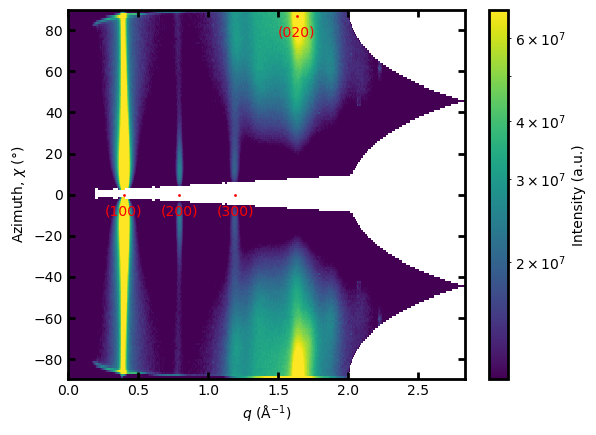

In [9]:
# User specified Miller indices (h1, k1, l1) and approximate chi value
h1, k1, l1 = 1, 0, 0 
approx_chi = 0

# Calculate 'Interplanar Angle' and 'Chi'
spacing_table = analyzer.calculate_interplanar_and_chi(spacing_table, h1, k1, l1, approx_chi = approx_chi)

# Generate the chi-q plot
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

# Plot a circle at the chi and q of the user-specified Miller index
ref_q = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'QSpace_AngstromInverse'].values[0]
ax.plot(ref_q, approx_chi, marker='.', markersize=2, color='red')

# Iterate through the rest of the list and plot the interplanar angles
for idx, row in spacing_table.iterrows():
    q = row['QSpace_AngstromInverse']
    chi = row['Chi']

    # If the current point is the reference point, skip it
    if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
        ax.annotate(f'({abs(int(h1))}{abs(int(k1))}{abs(int(l1))})', (ref_q, approx_chi), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=10)
        continue

    # Plot a small dot for each other Miller index within the range of -90 to 90
    if -90 <= chi <= 90:
        ax.plot(q, chi, marker='.', markersize=2, color='red')
        ax.annotate(f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', (q, chi), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=10)

plt.show()

Below is the indexed GIWAXS image of a spun-cast P3HT thin film.

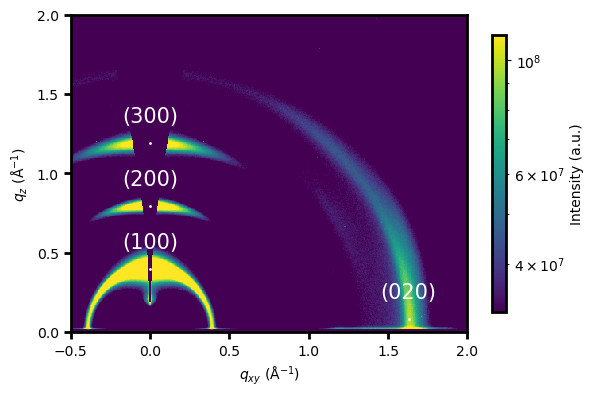

In [10]:
qxy_lower, qxy_upper = -0.5, 2 
qz_lower, qz_upper = 0, 2  

cmap = mpl.cm.viridis
cmap.set_bad((68/255, 1/255, 84/255), 1)

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap=cmap)

spacing_table = analyzer.compute_q_coordinates(spacing_table)

# Add your texts to a list instead of the plot
texts = []

# Plot a circle at the qxy and qz of the user-specified Miller index
ref_qxy = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qxy'].values[0]
ref_qz = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qz'].values[0]
ax.plot(ref_qxy, ref_qz, marker='.', markersize=2, color='white')
ax.annotate(f'({int(h1)}{int(k1)}{int(l1)})', (ref_qxy, ref_qz), textcoords="offset points", xytext=(0,15), ha='center', fontsize=15, color='white')

for idx, row in spacing_table.iterrows():
    qxy = row['qxy']
    qz = row['qz']

    # Only plot points and labels if they're within the user-specified axis limits
    if qxy >= qxy_lower and qxy <= qxy_upper and qz >= qz_lower and qz <= qz_upper:
        # Skip the reference point
        if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
            continue
        ax.plot(qxy, qz, marker='.', markersize=2, color='white')
        ax.annotate(f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', (qxy, qz), textcoords="offset points", xytext=(0,15), ha='center',  fontsize=15, color='white')

plt.show()

You can also print the calculated values if they are of interest.

In [11]:
spacing_table

,h,k,l,RealSpace_Angstroms,QSpace_AngstromInverse,Interplanar Angle,Chi,qxy,qz
0,1,0,0,15.800000,0.397670,0.0,0.0,0.00000,0.397670
1,2,0,0,7.900000,0.795340,0.0,0.0,0.00000,0.795340
2,3,0,0,5.266667,1.193010,0.0,0.0,0.00000,1.193010
3,0,2,0,3.850000,1.631996,87.0,87.0,1.62976,0.085412
4,0,-2,0,3.850000,1.631996,-93.0,-93.0,-1.62976,-0.085412


# Orientational Analysis

}If you are familiar with xarray, access to the $\text{qzqxy}$, $\text{chiq}$, and $\text{corrected_chiq}$ xarrays makes it convenient for various analysis, such as pole figure generation. For example, you can analyze the orientational distribution of the (020) peak, located between 1.6 and 1.68 Å$^{-1}$. 

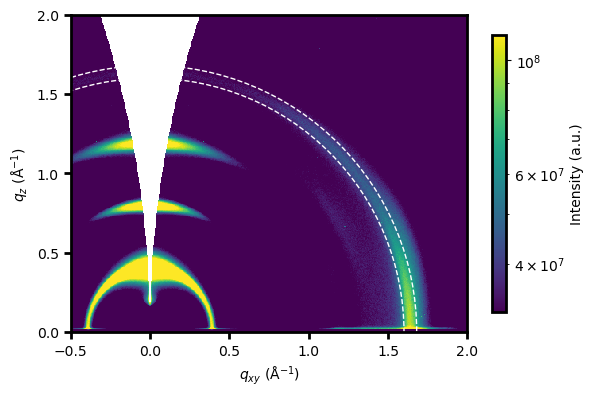

In [12]:
q_lower = 1.6
q_upper = 1.68

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap='viridis')

circle_lower = Circle((0, 0), q_lower, color='white', fill=False, linestyle='dashed', linewidth=1)
circle_upper = Circle((0, 0), q_upper, color='white', fill=False, linestyle='dashed', linewidth=1)

ax.add_artist(circle_lower)
ax.add_artist(circle_upper)

plt.show()

It is important to note that information within the missing wedge (near 0°) is inaccessible, so the resultant distribution assumes no population centered near 0°.

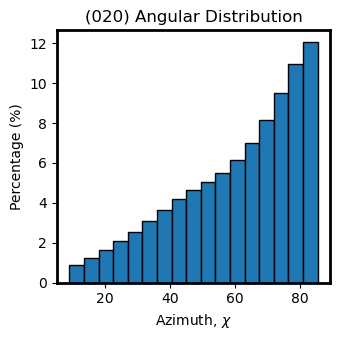

In [13]:
negative_chi = corrected_chiq.sel(q=slice(q_lower,q_upper), chi=slice(-90,0)).mean('q')
negative_chi['chi'] = abs(negative_chi['chi'])
positive_chi = corrected_chiq.sel(q=slice(q_lower,q_upper), chi=slice(0,90)).mean('q')

chi_common = np.linspace(0, 90, num=100)
negative_chi = negative_chi.interp(chi=chi_common)
positive_chi = negative_chi.interp(chi=chi_common)

# averaging the two datasets
average_chi = 0.5 * (negative_chi + positive_chi)

# Normalize the data so it sums to 1
normalized_chi = average_chi / average_chi.sum()

# Convert to percentage
percentage_chi = normalized_chi * 100

# Create a histogram plot
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax.hist(percentage_chi['chi'], weights=percentage_chi, bins=20, edgecolor='black')
ax.set_xlabel('Azimuth, $\\it{χ}$')
ax.set_ylabel('Percentage (%)')
plt.title('(020) Angular Distribution')
plt.tight_layout()
plt.show()

As an exercise, consider analyzing the $\text{LaB}_6$ calibration file included in the example data to verify that the isotropic $\text{LaB}_6$ standard gives scattering with random angular distribution.

# Depth Profiling

Next, let's consider depth profiling, which is possible because the penetration depth of X-rays is proportional to the incidence angle  according to:

$$
\Lambda = \frac{\lambda}{4\pi} \sqrt{\frac{2}{\sqrt{(\alpha_i^2 - \alpha_c^2)^2 + 4\beta^2} - (\alpha_i^2 - \alpha_c^2)}}
$$


where:

- $\Lambda$ is the penetration depth.
- $\lambda$ is the wavelength.
- $\alpha_i$ is the grazing incidence angle (less than 1 degree).
- $\alpha_c$ is the critical angle.
- $\beta$ is the imaginary part of the material's refractive indices at the given X-ray energy.


$$
\alpha_c = \sqrt{2\delta}
$$


where:

- $\alpha_c$ is the critical angle.
- $\delta$ is the real part of the material's refractive indices at the given X-ray energy..


We can estimate $\delta$ and $\beta$ using kkcalc (based on the Henke database for atomic scattering factors and Kramers-Kronig relations) knowing the density and stoichiometry. 

In [14]:
chemical_formula = 'C10H14S'
density = 1.1 # g/mol

delta, beta = Calculation.calc_refractive_index(xray_en, density, chemical_formula)
alpha_c = Calculation.calc_critical_angle(delta)

Once we have these values, we can apply the above equations to plot the expected penetration depth versus grazing incidence angle

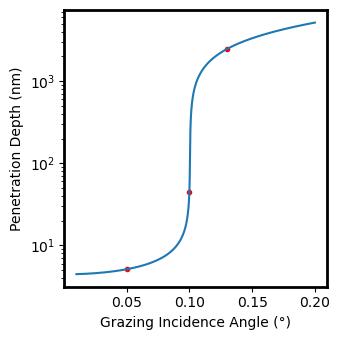

In [15]:
alpha_c = np.degrees(np.sqrt(2 * delta))
alpha_i = np.linspace(0.01,0.2,1001)
penetration_depth = Calculation.calc_penetration_depth(xray_en, alpha_i, alpha_c, beta)

shallow_angle = 0.05
critical_angle = 0.10
deep_angle = 0.13

shallow_penetration = Calculation.calc_penetration_depth(xray_en, shallow_angle, alpha_c, beta) / 10 # convert from angstrom to nm
critical_penetration = Calculation.calc_penetration_depth(xray_en, critical_angle, alpha_c, beta) / 10 # convert from angstrom to nm
deep_penetration = Calculation.calc_penetration_depth(xray_en, deep_angle, alpha_c, beta) / 10 # convert from angstrom to nm

fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax.plot(alpha_i,penetration_depth/10)
ax.scatter(shallow_angle, shallow_penetration, color='red', marker='.')
ax.scatter(critical_angle, critical_penetration, color='red', marker='.')
ax.scatter(deep_angle, deep_penetration, color='red', marker='.')
ax.set_xlabel('Grazing Incidence Angle (°)')
ax.set_ylabel('Penetration Depth (nm)')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

The 3 highlighted points at 0.05°, 0.10°, and 0.13° correspond the grazing incidence angles for the three .tif files in the .\example_data\P3HT_5wtpct_HTFSI_MeOH_2_Day folder. This can be confirmed by the 'th' motor position in the corresponding text files.

Let's go ahead and compare the GIWAXS scattering profiles for each image.

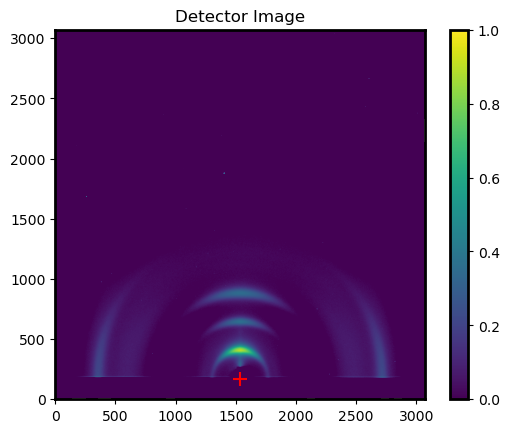

In [16]:
px_size_x, px_size_y = 0.073242, 0.073242 # mm, mm
bc_x, bc_y = 1535.46, 2908 # pixel coordinates
R = 315.395 # mm
xray_en= 12.7 # keV
q_range = 2 # inv A
q_res = 0.01 # inv A


incidence = 0.05 # degrees

file = r'.\example_data\P3HT_5wtpct_HTFSI_MeOH_2_Day\P3HT_5wtpct_HTFSI_MeOH_2_Day_0p05to0p13_0p0025_int_100s_02271630_0001.tif'
image = np.flipud(fabio.open(file).data)
masked_image, mask = processor.automask(image, threshold_value=2)
qzqxy_0p05 = processor.img_to_qzqxy(masked_image, bc_x, bc_y, R, incidence, px_size_x, px_size_y, q_range, q_res, xray_en)
chiq_0p05, corrected_chiq_0p05 = processor.cake_and_corr(qzqxy_0p05)


incidence = 0.10 # degrees

file = r'.\example_data\P3HT_5wtpct_HTFSI_MeOH_2_Day\P3HT_5wtpct_HTFSI_MeOH_2_Day_0p05to0p13_0p0025_int_100s_02271630_0021.tif'
image = np.flipud(fabio.open(file).data)
masked_image, mask = processor.automask(image, threshold_value=2)
qzqxy_0p10 = processor.img_to_qzqxy(masked_image, bc_x, bc_y, R, incidence, px_size_x, px_size_y, q_range, q_res, xray_en)
chiq_0p10, corrected_chiq_0p10 = processor.cake_and_corr(qzqxy_0p10)


incidence = 0.13 # degrees

file = r'.\example_data\P3HT_5wtpct_HTFSI_MeOH_2_Day\P3HT_5wtpct_HTFSI_MeOH_2_Day_0p05to0p13_0p0025_int_100s_02271630_0033.tif'
image = np.flipud(fabio.open(file).data)
masked_image, mask = processor.automask(image, threshold_value=2)
qzqxy_0p13 = processor.img_to_qzqxy(masked_image, bc_x, bc_y, R, incidence, px_size_x, px_size_y, q_range, q_res, xray_en)
chiq_0p13, corrected_chiq_0p13 = processor.cake_and_corr(qzqxy_0p13)

# Make sure the beam center is correct
plt.imshow(masked_image, origin = 'lower', norm=LogNorm(np.nanpercentile(image, 80)))
plt.scatter(bc_x, image.shape[1] - bc_y, color='red', s=100, marker='+', label='Beam Center')
plt.colorbar()
plt.title('Detector Image')
plt.show()

Note below that $\text{chiq}$ or $\text{corrected_chiq}$ can be integrated radially (about all $\chi$) to produce the familar 1D scattering intensity versus $q$ plot. This can be achieved in xarray by taking the mean over all $\chi$, leaving intensity versus $q$.

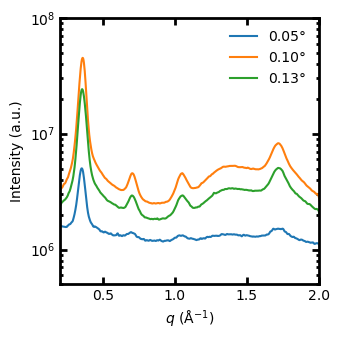

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)

corrected_chiq_0p05.mean('chi').plot(ax = ax, label = '0.05°')
corrected_chiq_0p10.mean('chi').plot(ax = ax, label = '0.10°')
corrected_chiq_0p13.mean('chi').plot(ax = ax, label = '0.13°')

ax.set_xlabel('${q}$ (Å$^{-1})$')
ax.set_ylabel('Intensity (a.u.)')
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top=True)
ax.yaxis.set_tick_params(which='major', size=5, width=2, direction='in', right=True)
ax.yaxis.set_tick_params(which='minor', size=2.5, width=2, direction='in', right=True)
ax.set_yscale('log')
ax.set_xlim([0.2, 2])
ax.set_ylim([5e5, 1e8])
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

One can immediately see that the scattering at the most shallow angle is different from that at the higher angles (beyond being lower signal-to-noise). 

This is data from a paper that studies diffusion limitations of a dopant through a P3HT thin film (DOI 10.1039/D3TC00415E), where it was found that the dopants penetrate the top 20 - 30 nm of a 265 nm-thick P3HT film. The effect that we're seeing here is that the crystal structure at the surface is impacted by the ingress of these dopants whereas scattering at steeper angles is dominated by the the largely undoped material further past the film surface. 

Also note that scattering near the critical angle (0.10°) is more intense than at 0.13° despite the X-rays penetrating deeper at 0.13°. This is because (1) penetration past the material's thickness does not result in additional scattering and (2) the footprint of the incident beam decreases with increasing angle, exposing less material.

If we evaluate the penetration depths, we see that our scattering profiles are in line with the explanation above and in the paper.

In [18]:
shallow_penetration # nm

5.107627686014736

In [19]:
critical_penetration # nm

45.20037663472506

In [20]:
deep_penetration # nm

2471.4616270300876